In [2]:
%pylab inline
import seaborn as sns
sns.set_style('ticks', {'axes.grid': True})
sns.set_context('poster', font_scale=2.0)
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = (12.8, 9.6)
plt.rcParams['figure.facecolor'] = 'white'


Populating the interactive namespace from numpy and matplotlib


In [3]:
import scipy.optimize
import scipy.constants as sc
import pickle
import os

In [4]:
print(scipy.__version__)
print(sns.__version__)
print(matplotlib.__version__)

1.0.0
0.8.1
2.2.2


# import data and scales

In [5]:
with open('../data/Meffs.pickle', 'rb') as f:
    Meffs = pickle.load(f)

with open('../data/Eeffs.pickle', 'rb') as f:
    Eeffs = pickle.load(f)

with open('../data/dEeffs.pickle', 'rb') as f:
    dEeffs = pickle.load(f)
    
with open('../data/dE_fits.pickle', 'rb') as f:
    dE_fits = pickle.load(f)


In [6]:
hbarc = sc.hbar * sc.speed_of_light / sc.electron_volt / sc.femto / sc.mega # 197 MeV fm

In [7]:
ainv = 2.194e3 # lattice cutoff [MeV]
lat_unit = hbarc / ainv # lattice spacing [fm]

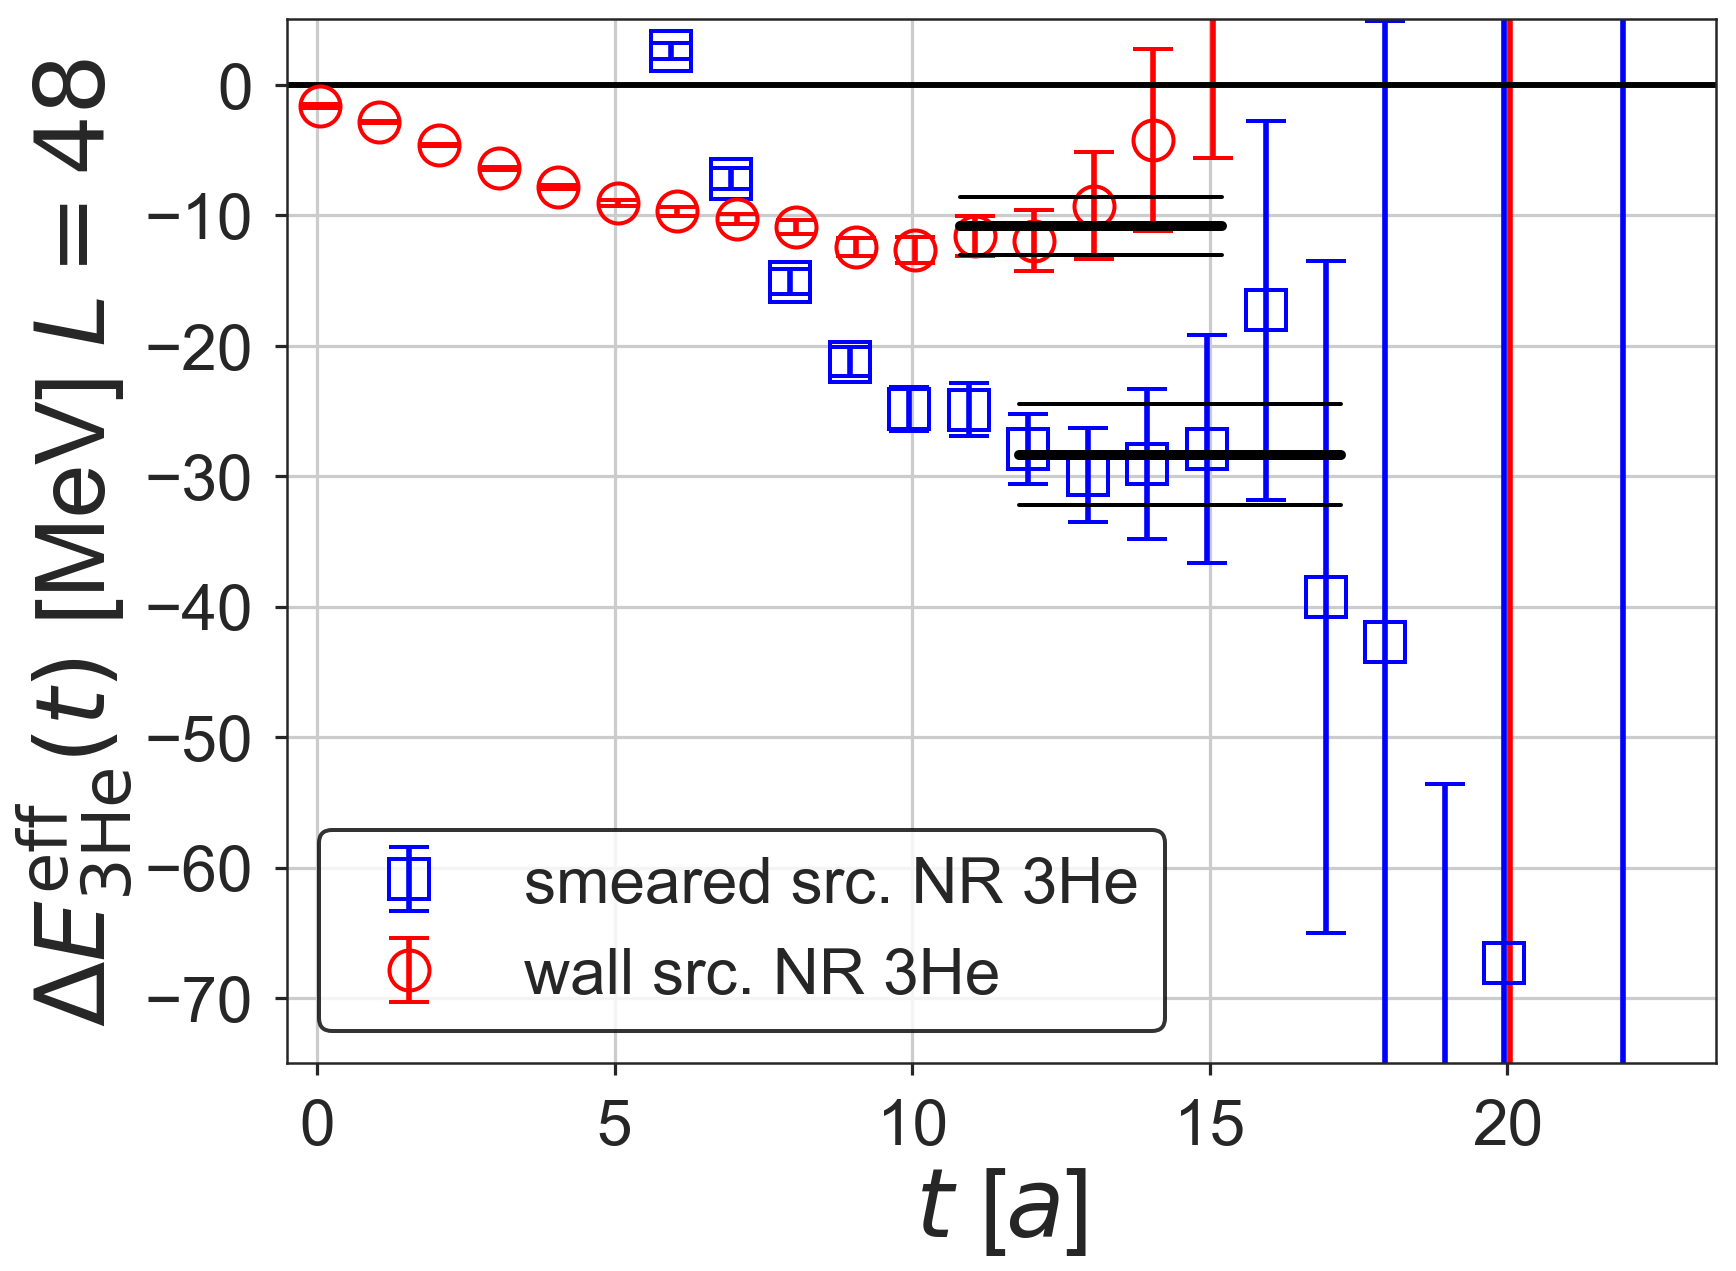

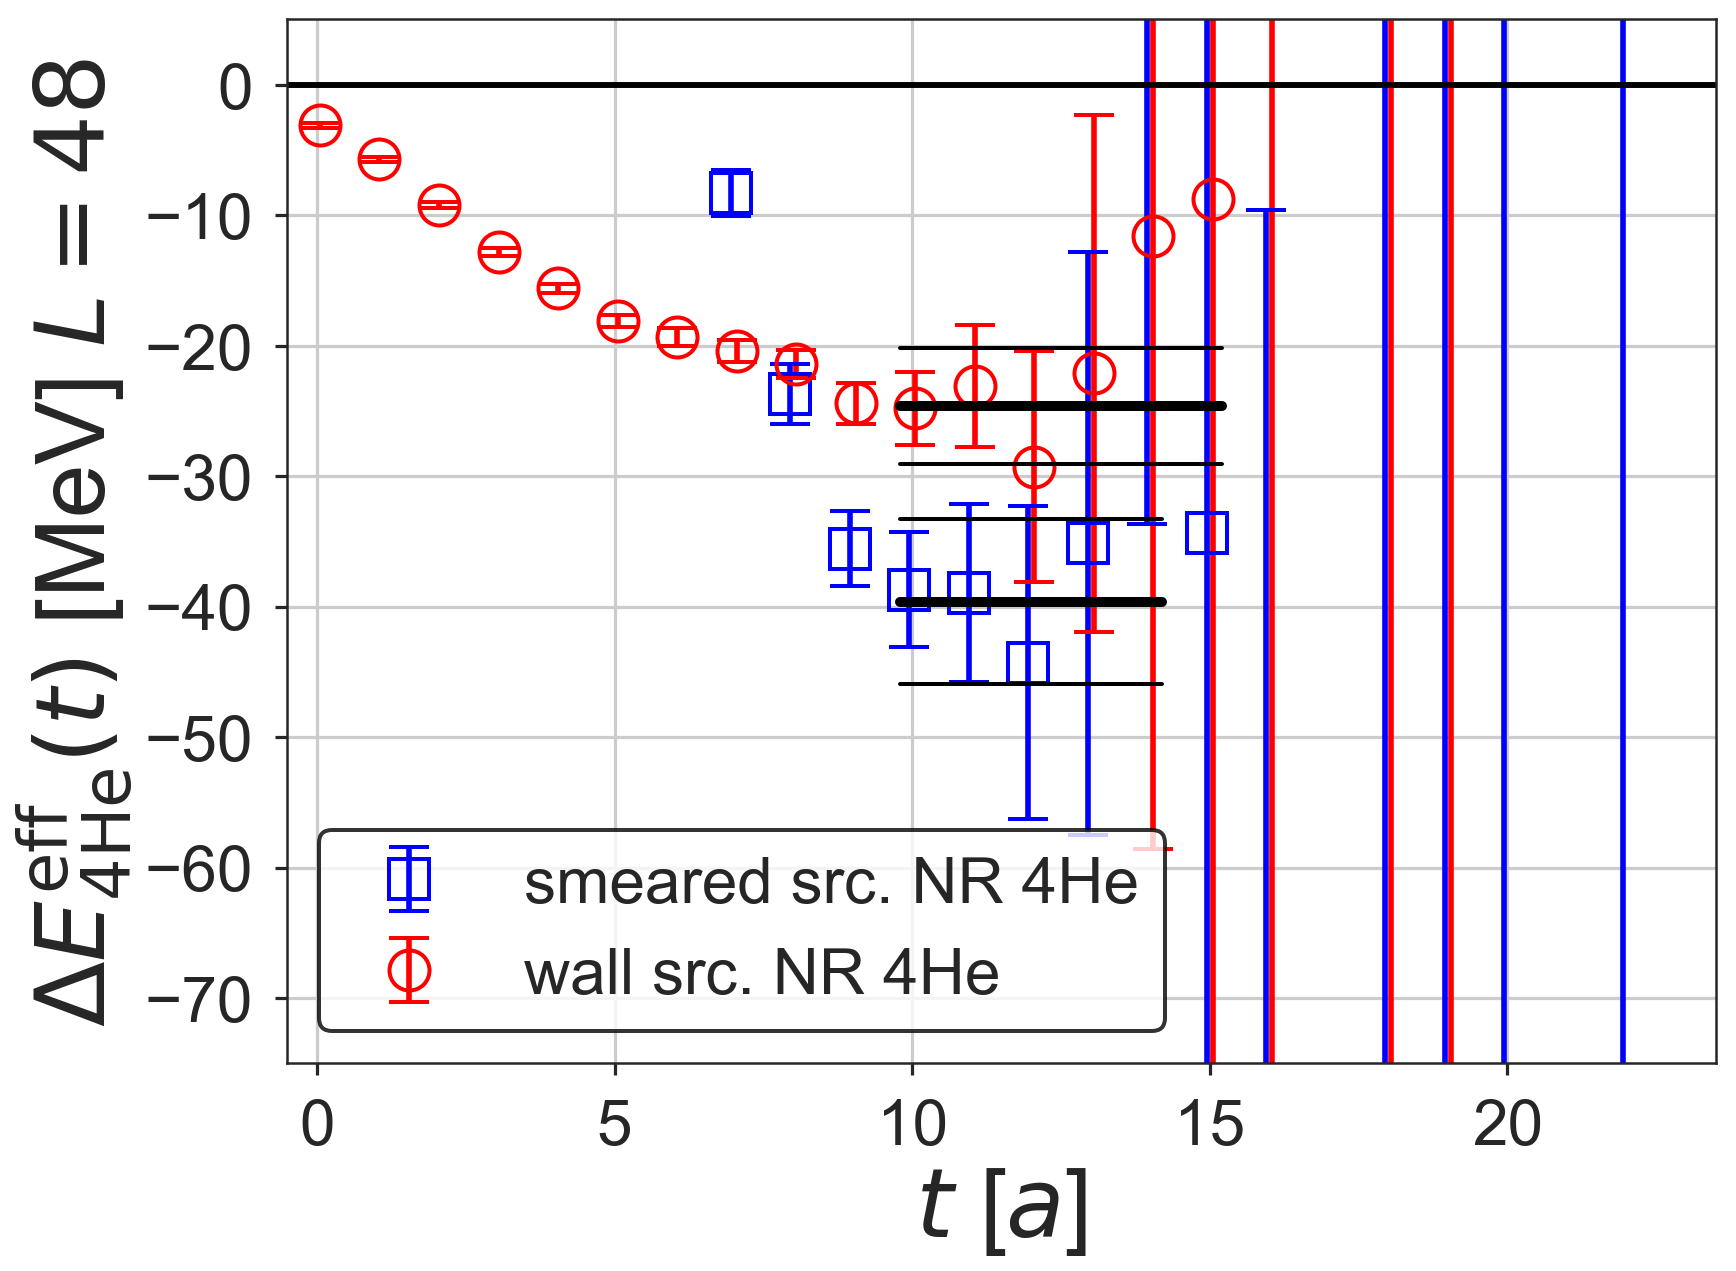

In [8]:
def plot_dEeff_triton_helium(L=48, rela='rela', ch='triton', yr=(-75, 5), figs_dir='../figs/triton_helium'):
    ch_label = {'triton': '3He', 'helium': '4He'}[ch]

    fig, ax = plt.subplots()
    for src, col, fmt, dx in zip(['smeared', 'wall'], ['blue', 'red'], ['s', 'o'], [-0.05, 0.05]):
        dat = dEeffs[(L, src, rela, ch)]
        ax.errorbar(dat[:,0] + dx, dat[:,3]*ainv, dat[:,4]*ainv, fmt=fmt,
                    capsize=10, capthick=2.0, ms=20, color=col, mfc='none', mew=2.0,
                   label=r'{} src. {} {}'.format(src, rela, ch_label))

        ax.set_xlim(-0.5, 23.5)
        ax.axhline(0, color='black')
        fit_min, fit_max, fit_val, fit_err = dE_fits[(L, src, rela, ch)]
        xls = np.linspace(fit_min-0.2, fit_max+0.2)
        ax.plot(xls, np.ones_like(xls) * fit_val * ainv, color='black', lw=5, zorder=5)
        ax.plot(xls, np.ones_like(xls) * (fit_val + fit_err)* ainv, color='black', lw=2, zorder=5)
        ax.plot(xls, np.ones_like(xls) * (fit_val - fit_err)* ainv, color='black', lw=2, zorder=5)

    ax.set_ylim(yr)
    leg = ax.legend(frameon=True)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(2.0)
    ax.set_xlabel(r'$t$ [$a$]', size=48)
    ax.set_ylabel(r'$\Delta E^\mathrm{{eff}}_\mathrm{{{}}}(t)$ [MeV] $L = {}$'.format(ch_label, L), size=48)
    
    if not os.path.exists(figs_dir):
        os.makedirs(figs_dir)
        
    fname = f'{figs_dir}/dEeff_{ch}_L{L}_{rela}.pdf'
    fig.savefig(fname, bbox_inches='tight')

for ch in ['triton', 'helium']:
    plot_dEeff_triton_helium(rela='NR', ch=ch)

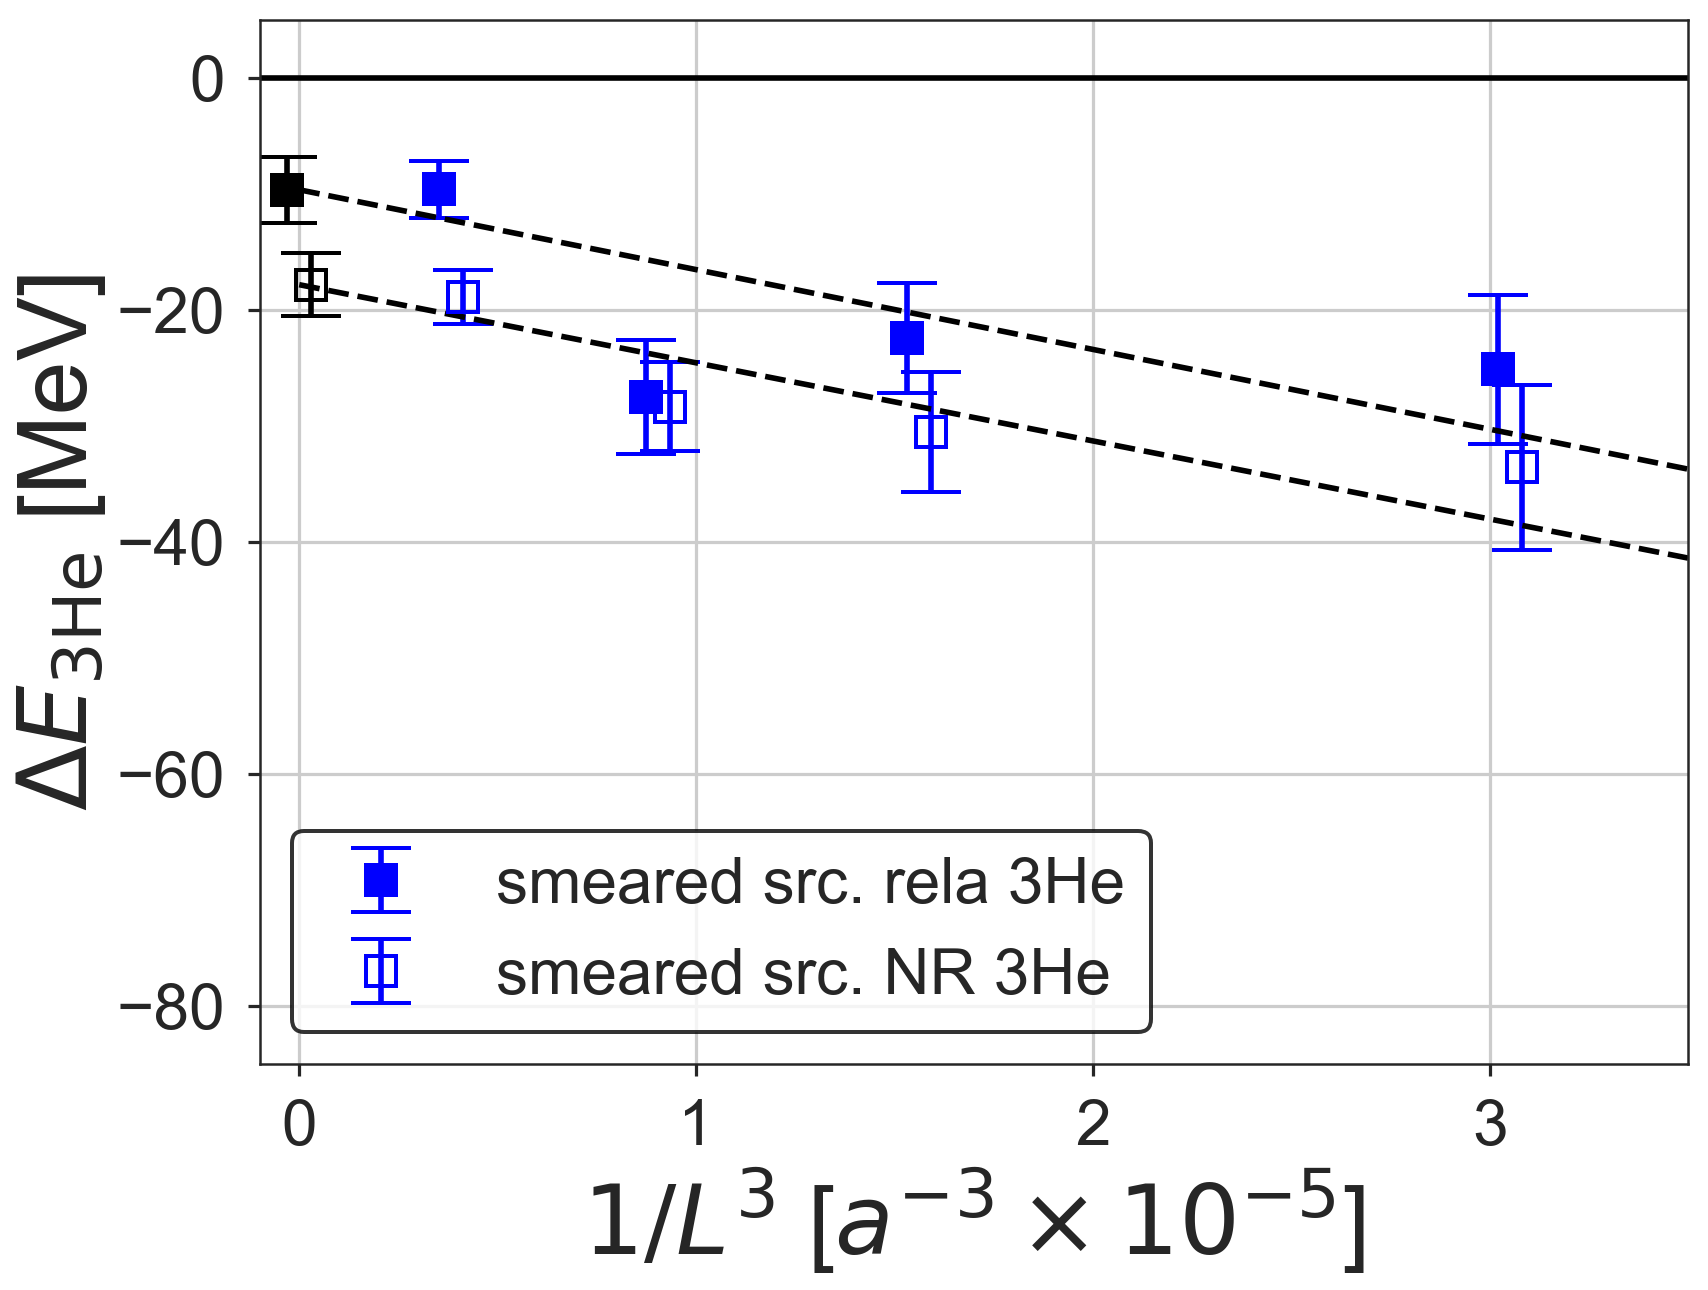

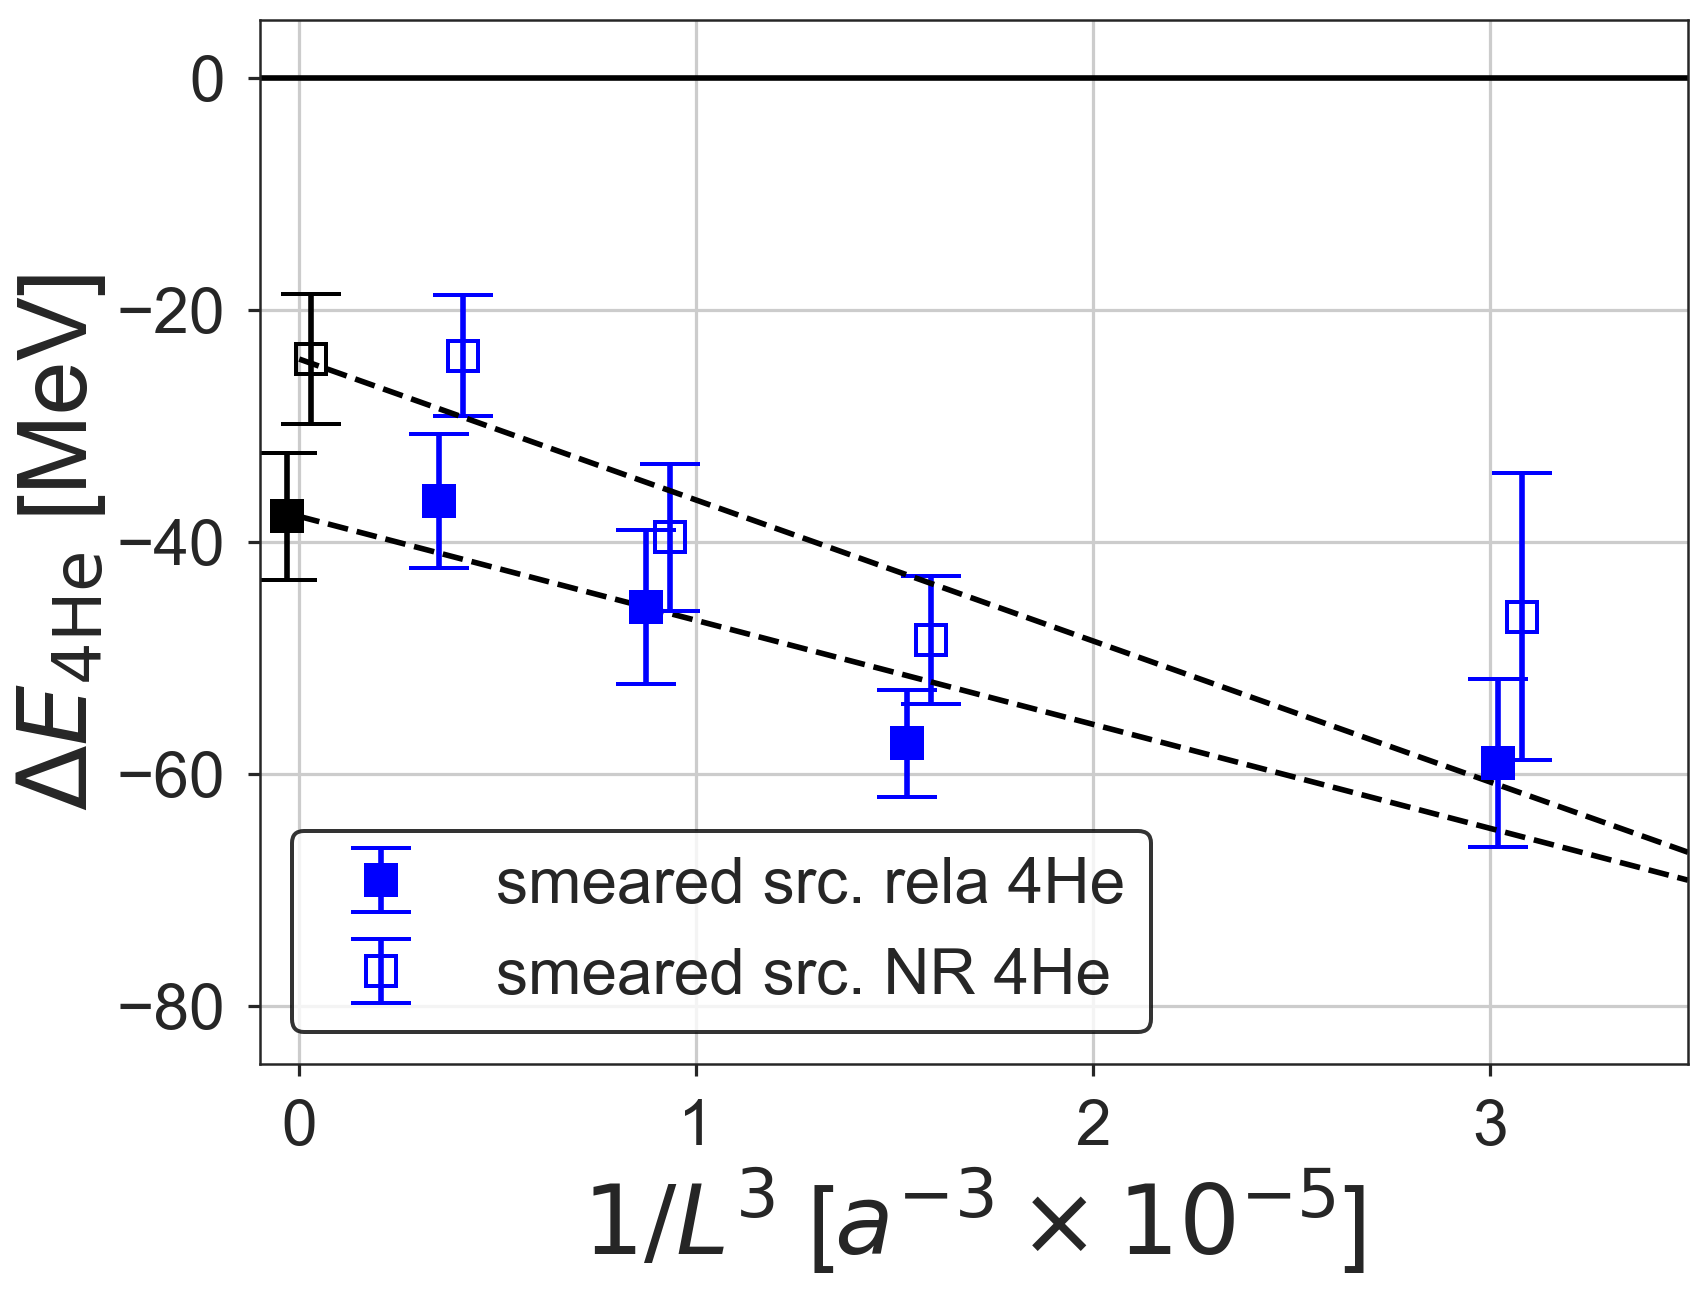

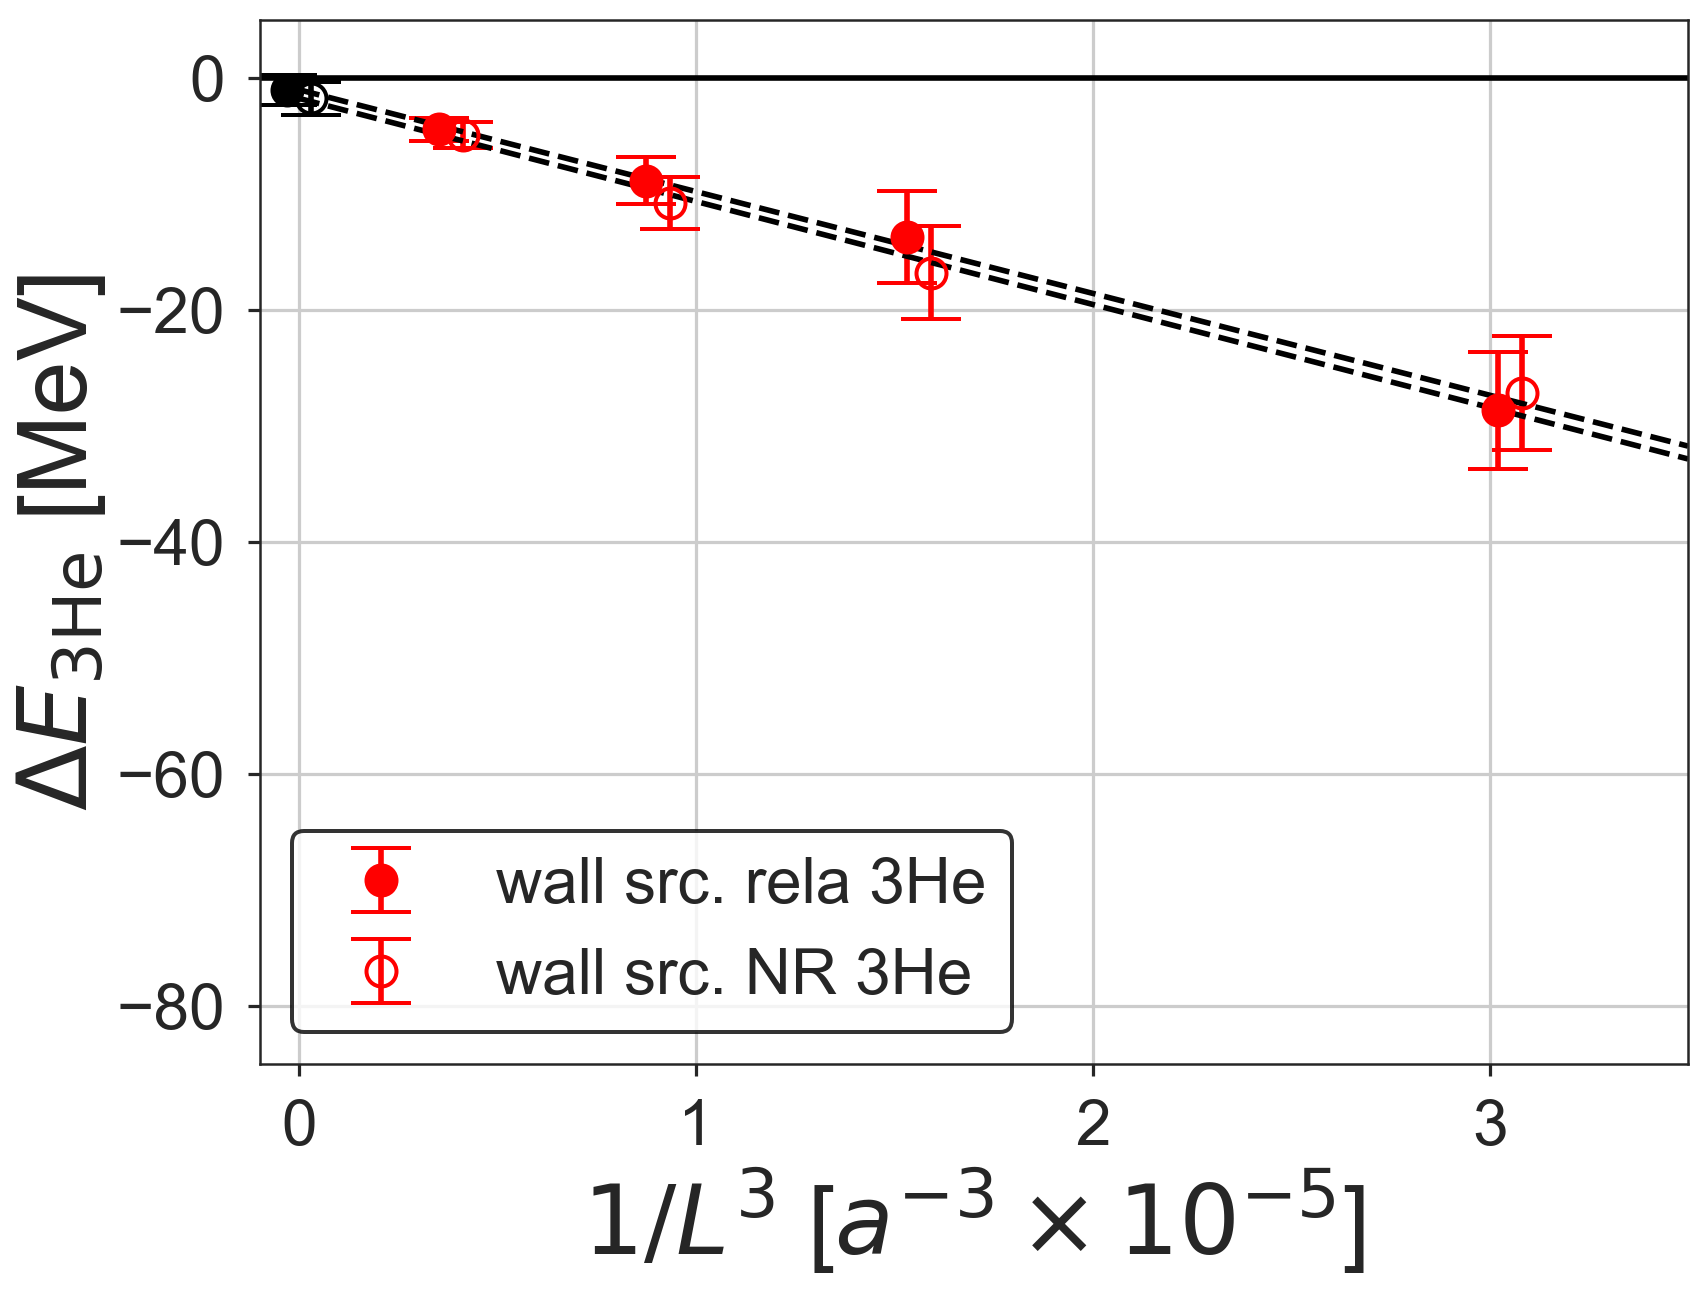

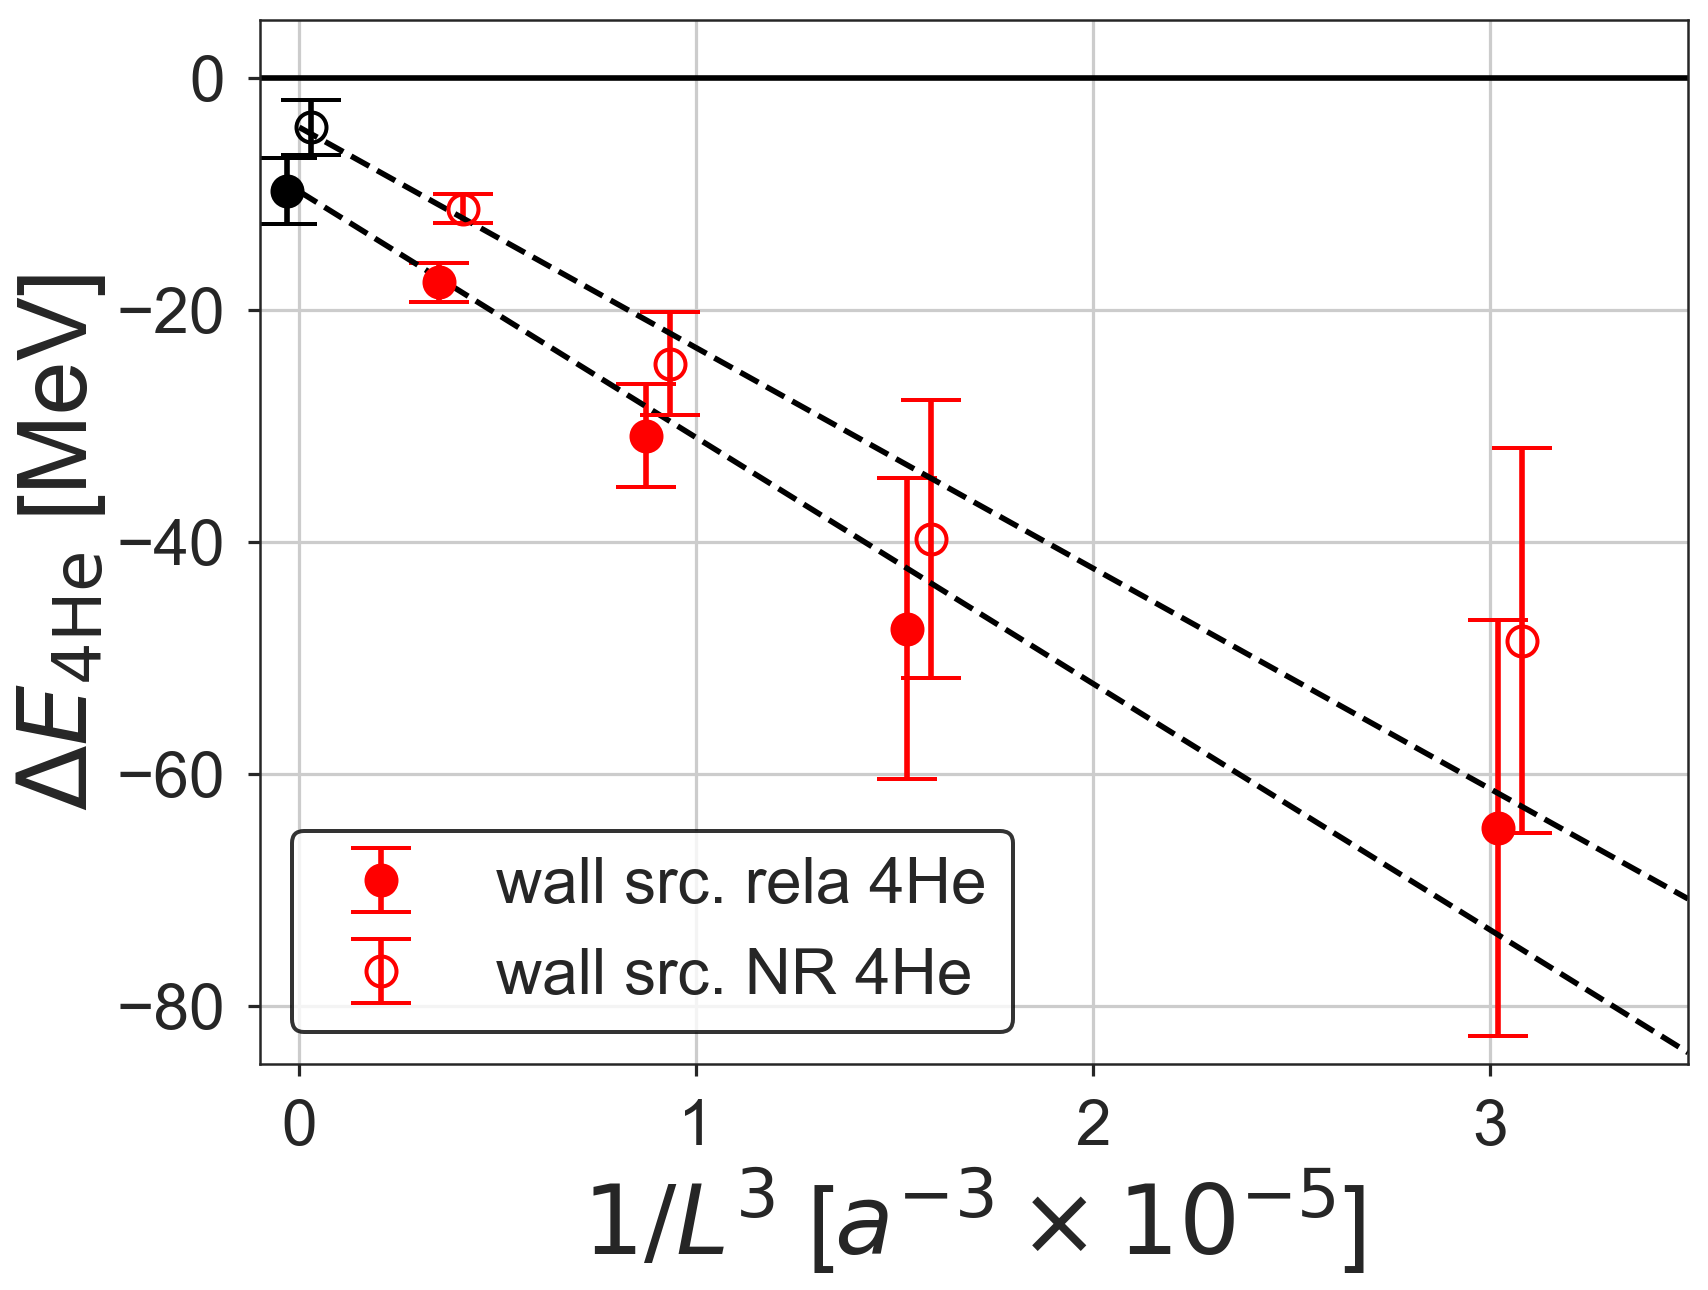

In [9]:
def plot_dE_inf(src='smeared', ch='XiXi', yr=(-85, 5), figs_dir='../figs/triton_helium'):
    col = {'wall': 'red', 'smeared': 'blue'}[src]
    ch_label = {'triton': r'3He', 'helium': r'4He'}[ch]
    fmt = {'wall': 'o', 'smeared': 's'}[src]

    fig, ax = plt.subplots()
    Ls = np.array([32, 40, 48, 64])
    fac = 1.0e5
    for rela, dx, mfc1, mfc2 in zip(['rela', 'NR'], [-0.03, 0.03], [col, 'none'], ['black', 'none']):
        dEs = []
        dEerrs = []
        for L in Ls:
            fit_min, fit_max, fit_val, fit_err = dE_fits[(L, src, rela, ch)]
            dEs.append(fit_val)
            dEerrs.append(fit_err)
        dEs = np.array(dEs)
        dEerrs = np.array(dEerrs)

        ax.errorbar(1.0/Ls**3 * fac + dx, dEs*ainv, dEerrs*ainv, fmt=fmt,
                    capsize=15, capthick=2.0, ms=15, color=col, mfc=mfc1, mew=2.0, 
                   label=r'{} src. {} {}'.format(src, rela, ch_label))
        
        flin = lambda p, x: p[0] + p[1]*x
        errf = lambda p, y, x, err: (flin(p,x)-y)/err
        pfit = scipy.optimize.leastsq(errf, [0.1, 0.1], args=(dEs*ainv, 1.0/Ls**3*fac,
                                                             dEerrs*ainv), full_output=True)
        ax.errorbar([dx], pfit[0][0], np.sqrt(pfit[1][0,0]), fmt=fmt, color='black',
                   capsize=15, capthick=2.0, ms=15, mfc=mfc2, mew=2.0)
        xls = np.linspace(0, 3.5)
        ax.plot(xls, flin(pfit[0],xls), color='black', linestyle='--')

    ax.set_xlim(-0.1, 3.5)
    ax.axhline(0, color='black')
#    ax.axvline(0, color='black')

    ax.set_ylim(yr)
    leg = ax.legend(frameon=True)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(2.0)
    ax.set_xlabel(r'$1/L^3$ [$a^{-3} \times 10^{-5}$]', size=48)
    ax.set_ylabel(r'$\Delta E_\mathrm{{{}}}$ [MeV]'.format(ch_label), size=48)
    
    if not os.path.exists(figs_dir):
        os.makedirs(figs_dir)
    fname = f'{figs_dir}/dE_inf_{ch}_{src}.pdf'
    fig.savefig(fname, bbox_inches='tight')
    
for src in ['smeared', 'wall']:
    for ch in ['triton', 'helium']:
        plot_dE_inf(src=src, ch=ch)